# Task 3: Q-learning for mobile robot navigation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
### auxiliary functions

def action_decode(act_code):
    dirs = {0: "N", 1: "E", 2: "S", 3: "W"}
    return dirs[act_code]

def action_encode(act):
    dir_codes = {"N": 0, "E": 1, "S": 2, "W": 3}
    return dir_codes(act)

def display_learning(series, label):
    n_episodes = len(series)
    show_n = 20
    show_step = int(n_episodes/show_n)
    sequence = []
    for i in range(show_n):
        sequence.append(np.mean(series[show_step*i:show_step*(i+1)]))
        print((i+1) * show_step, ' episodes ', label, sequence[-1])
    print('\n')
    plt.figure()
    plt.plot(sequence)
    plt.ylabel(label)
    plt.xlabel('episodes')

The following functions were defined in this cell

action_decode, action_encode, and display_learning.

action_decode - to map the action taken by the agent during training from a numerical value (0-3) to a string representation of the cardinal direction (N, E, S, W).

action_encode - it does the reverse of action_decode. Given a string representation of a cardinal direction, it returns the numerical code for that direction (0-3).

display_learning - to plot the learning progress of the agent during training. It takes a list of reward values (i.e., series) and a string label as arguments. The function then computes the average reward for every 20 episodes of training and stores the value in a list sequence. The plot of the sequence is then displayed with the label and the x-axis labeled as episodes.

In [2]:
class grid_env():
### definition of the maze environment

    def __init__(self, width = 5, height = 5, start = [0, 0], debug = False):
        # Contructor methods create the environment with some given options
        self.width = width
        self.height = height
        self.start = start
        self.goal = [self.width - 1, self.height - 1]
        self.debug = debug
        self.n_states = self.width * self.height
        self.reset()
        
    def reset(self):
        # Reset method puts the state at the starting position
        self.pos = self.start[:]   # columns, rows
        return self.pos, 0, False        

    def state_decode(self, obs_code):
        r = obs_code // self.width
        c = obs_code % self.width
        return([c, r])
    
    def state_encode(self, position):
        code = position[0] + position[1] * (self.width) # columns, rows
        return(code)

    def step(self, action):
        # Depending on the action, update the environment state
        if action == "S" and (self.pos[1] < self.height -1):
            self.pos[1] += 1
        elif action == "N" and self.pos[1] > 0:
            self.pos[1] -= 1
        elif action == "W" and self.pos[0] > 0:
            self.pos[0] -= 1
        elif action == "E" and (self.pos[0] < self.width -1):
            self.pos[0] += 1

        done = (self.pos == self.goal)  # check if goal was reached
        if done:
            reward = self.width + self.height  # reward at goal
        else:
            reward = -1  # negative reward at every step

        if self.debug:
            print(self.render())

        return self.pos, reward, done

    def render(self):
        res = ""
        for y in range(self.height):
            for x in range(self.width):
                if self.goal[0] == x and self.goal[1] == y:
                    if self.pos[0] == x and self.pos[1] == y:
                        res += "@"
                    else:
                        res += "o"
                    continue
                if self.pos[0] == x and self.pos[1] == y:
                    res += "x"
                else:
                    res += "_"
            res += "\n"
        return(res)

This cell sets the agent's grid_env. The agent navigates a maze. The __init__ method specifies environment width, height, beginning position, goal position, and debug mode. Resetting the agent's starting position resets the environment's position, reward, and done state.

state_decode retrieves row and column values from an observation code. State_encode reverses state_decode. It yields the observation's row and column code.


Step advances the agent based on an activity. The agent receives the maze's breadth and height if they succeed. If not, each step earns -1. If the agent achieves the goal, done is True. Rendering visualises the environment.

In [3]:
class agent():
### definition of the agent

    def __init__(self, n_obs, discount = 1, learning_rate = 0.1, eps = {'start': 1, 'min': 0.01, 'decay': 0.001}):
        self.action_space = np.asarray([0, 1, 2, 3])  # north, east, south, west
        n_actions = np.shape(self.action_space)[0]
        self.Q_table = np.zeros((n_obs, n_actions))

        self.epsilon = eps['start']   #initialize the exploration probability to 1
        self.epsilon_decay = eps['decay']   #exploration decreasing decay for exponential decreasing
        self.epsilon_min = eps['min']   # minimum of exploration proba
        
        self.gamma = discount   #discounted factor
        self.alpha = learning_rate   #learning rate
    
    def action_selection(self, state):
        if np.random.uniform(0,1) < self.epsilon:
            action = self.action_space[np.random.randint(0, 3)]   # choose a random action with probability epsilon
        else:
            action = np.argmax(self.Q_table[state,:])  # choose the best action for that state with prob 1-epsilon
        return(action)

    def policy_update(self, action, reward, state, next_state):
        self.Q_table[state, action] = (1 - self.alpha) * self.Q_table[state, action] + self.alpha*(reward + self.gamma*max(self.Q_table[next_state,:]))

    def decrease_exploration(self, e):
        self.epsilon = max(self.epsilon_min, np.exp(-self.epsilon_decay*e))
        
#     def test_agent(self, env):
#         state, _, done = env.reset()
#         steps = 0
#         while not done and steps < 100:
#             action = ag.action_selection(env.state_encode(state))
#             next_state, reward, done = env.step(action_decode(action))
#             steps += 1
#         print(steps)
        
    #MODIFYING THIS TO SHOW THE AMOUNT OF STEPS AFTER A TEST IS DONE OR NOT DONE 
    def test_agent(self, env):
        state, _, done = env.reset()
        steps = 0
        while not done:
            action = ag.action_selection(env.state_encode(state))
            next_state, reward, done = env.step(action_decode(action))
            steps += 1
            if done and reward > 0:
                print(f"Target reached in {steps} steps.")
        if reward == 0:
            print("Target not reached.")


    def train(self, env, n_episodes = 1000, max_steps = 100):
        all_rewards = []
        all_steps = []
        for e in range(n_episodes):   # iterate over episodes
            state, _, done = env.reset()
            trial_reward = 0
            t = 0
            while not done and t < max_steps:
                action = ag.action_selection(env.state_encode(state))  # step 1: choose an action
                old_state = state[:]
                next_state, reward, done = env.step(action_decode(action))    # steps 2 and 3: The environment runs the chosen action and returns next state and reward
                ag.policy_update(action, reward, env.state_encode(old_state), env.state_encode(next_state))  # step 4: policy update
                trial_reward += reward
                t += 1
            ag.decrease_exploration(e)
            all_rewards.append(trial_reward)
            all_steps.append(t)
        return(all_rewards, all_steps)

This cell specifies the agent class. Initializes Q-table, exploration probability, discount factor, and learning rate.

action_selection returns the action based on the state. It chooses a random action with probability epsilon and the highest Q-value with probability 1-epsilon.

policy_update changes the Q-table depending on rewards, state, next state, and agent action.

decrease_exploration lowers epsilon.

test_agent evaluates the agent's environment performance. It resets the environment and follows the agent's policy until the objective or step limit is met. It returns the agent's goal-achieving steps.



250  episodes  reward  -53.876
500  episodes  reward  -24.82
750  episodes  reward  -12.192
1000  episodes  reward  -6.284
1250  episodes  reward  -3.4
1500  episodes  reward  -1.792
1750  episodes  reward  -0.432
2000  episodes  reward  0.372
2250  episodes  reward  1.148
2500  episodes  reward  1.416
2750  episodes  reward  1.852
3000  episodes  reward  2.012
3250  episodes  reward  2.344
3500  episodes  reward  2.488
3750  episodes  reward  2.6
4000  episodes  reward  2.64
4250  episodes  reward  2.764
4500  episodes  reward  2.808
4750  episodes  reward  2.864
5000  episodes  reward  2.86


250  episodes  steps  69.752
500  episodes  steps  45.316
750  episodes  steps  33.192
1000  episodes  steps  27.284
1250  episodes  steps  24.4
1500  episodes  steps  22.792
1750  episodes  steps  21.432
2000  episodes  steps  20.628
2250  episodes  steps  19.852
2500  episodes  steps  19.584
2750  episodes  steps  19.148
3000  episodes  steps  18.988
3250  episodes  steps  18.656
3500  episode

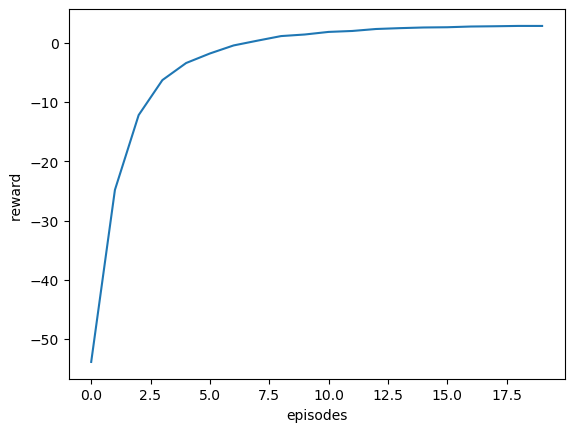

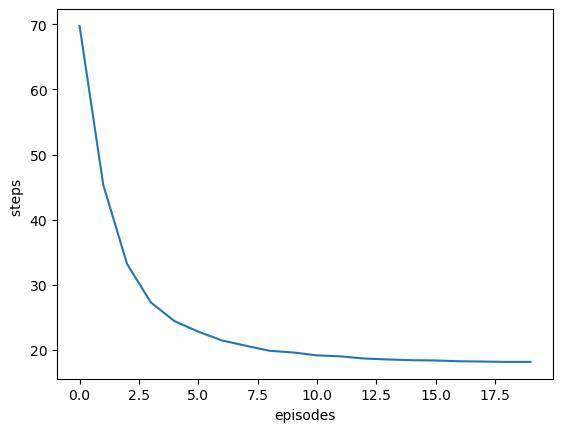

In [4]:
maze_height = 10
maze_width = 10
start = [0, 0]
maze = grid_env(maze_height, maze_width, start)

epsilon = {'start': 1, 'min': 0.01, 'decay': 0.001} # parameter epsilon needs to be a dictionary
ag = agent(maze.n_states, eps = epsilon) # only one parameter is compulsory, try adding different values of discount factor and learing rate
episodes = 5000
steps = 100
[rewards, steps] = ag.train(maze, episodes, steps)

display_learning(rewards, "reward ")
display_learning(steps, "steps ")

print(ag.Q_table)

maze = grid_env(maze_height, maze_width, start, debug = True)
ag.test_agent(maze)


This cell produces a grid_env object, a simple grid world environment. It defines epsilon's hyperparameters and produces an agent class instance using the environment's states. Finally, it trains the agent for a set number of episodes and maximum steps each episode and displays the rewards and steps learning curve. It prints the learned Q-table and checks the agent's environment performance. This code is an example and can be adjusted for the situation and context.

50  episodes  reward  -36.96
100  episodes  reward  -29.88
150  episodes  reward  -24.74
200  episodes  reward  -19.66
250  episodes  reward  -11.62
300  episodes  reward  -11.28
350  episodes  reward  -9.26
400  episodes  reward  -7.72
450  episodes  reward  -4.6
500  episodes  reward  -3.8
550  episodes  reward  -1.8
600  episodes  reward  -3.48
650  episodes  reward  -1.06
700  episodes  reward  -0.88
750  episodes  reward  -0.04
800  episodes  reward  0.38
850  episodes  reward  0.02
900  episodes  reward  0.74
950  episodes  reward  1.54
1000  episodes  reward  1.92


50  episodes  steps  42.56
100  episodes  steps  38.28
150  episodes  steps  34.26
200  episodes  steps  30.58
250  episodes  steps  24.78
300  episodes  steps  25.0
350  episodes  steps  22.7
400  episodes  steps  21.44
450  episodes  steps  18.6
500  episodes  steps  17.52
550  episodes  steps  15.8
600  episodes  steps  17.48
650  episodes  steps  15.06
700  episodes  steps  14.88
750  episodes  steps  14.04
800  

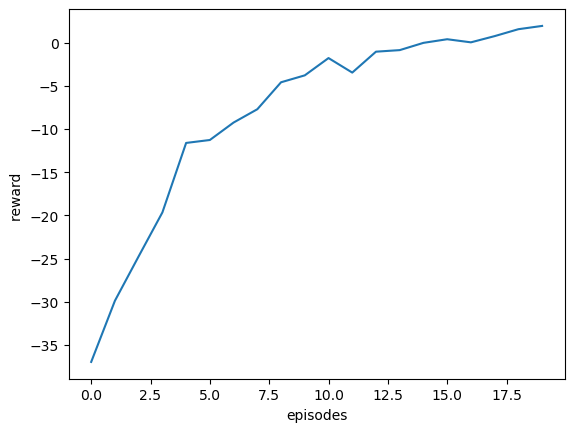

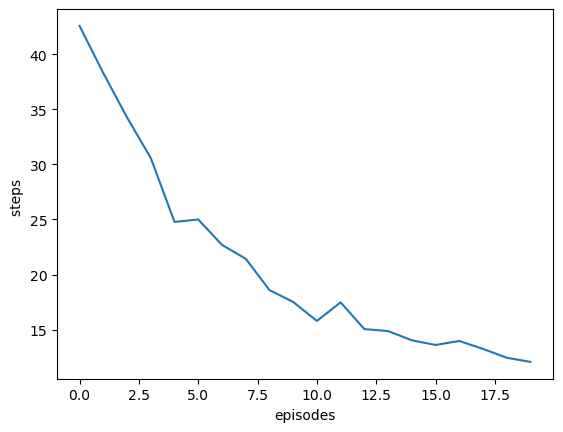

In [5]:
# set up the maze with a different size and start position
maze_height = 5
maze_width = 8
start = [2, 1]
maze = grid_env(maze_height, maze_width, start)

# set up the agent with different learning parameters
epsilon = {'start': 1, 'min': 0.01, 'decay': 0.001}
ag = agent(maze.n_states, discount=0.95, learning_rate=0.2, eps=epsilon)

# train the agent for a smaller number of episodes and steps
episodes = 1000
steps = 50
rewards, steps = ag.train(maze, episodes, steps)

# display the learning curves
display_learning(rewards, "reward ")
display_learning(steps, "steps ")

# print the learned Q-table
print(ag.Q_table)

# test the agent on a new maze instance
maze_test = grid_env(maze_height, maze_width, [0, 0], debug=True)
ag.test_agent(maze_test)


In this cell some modification was made
The maze_height and maze_width variables were changed

250  episodes  reward  -54.888
500  episodes  reward  -22.692
750  episodes  reward  -10.48
1000  episodes  reward  -5.34
1250  episodes  reward  -2.556
1500  episodes  reward  -1.048
1750  episodes  reward  0.088
2000  episodes  reward  0.8
2250  episodes  reward  1.38
2500  episodes  reward  1.7
2750  episodes  reward  2.068
3000  episodes  reward  2.244
3250  episodes  reward  2.512
3500  episodes  reward  2.632
3750  episodes  reward  2.68
4000  episodes  reward  2.744
4250  episodes  reward  2.804
4500  episodes  reward  2.876
4750  episodes  reward  2.888
5000  episodes  reward  2.912


250  episodes  steps  70.596
500  episodes  steps  43.188
750  episodes  steps  31.312
1000  episodes  steps  26.34
1250  episodes  steps  23.556
1500  episodes  steps  22.048
1750  episodes  steps  20.912
2000  episodes  steps  20.2
2250  episodes  steps  19.62
2500  episodes  steps  19.3
2750  episodes  steps  18.932
3000  episodes  steps  18.756
3250  episodes  steps  18.488
3500  episodes  ste

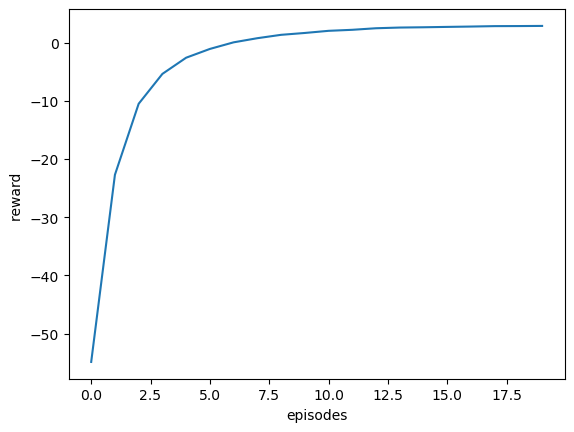

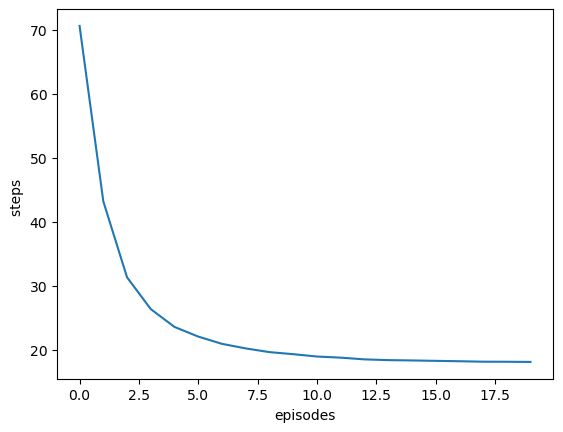

In [6]:
# this code is only an example, remove it or change it

maze_height = 10
maze_width = 10
start = [0, 0]
maze = grid_env(maze_height, maze_width, start)

epsilon = {'start': 1, 'min': 0.01, 'decay': 0.001} # parameter epsilon needs to be a dictionary
ag = agent(maze.n_states, eps = epsilon) # only one parameter is compulsory, try adding different values of discount factor and learing rate
episodes = 5000
steps = 100
[rewards, steps] = ag.train(maze, episodes, steps)

display_learning(rewards, "reward ")
display_learning(steps, "steps ")

print(ag.Q_table)

maze = grid_env(maze_height, maze_width, start, debug = True)
ag.test_agent(maze)


_x________
__________
__________
__________
__________
__________
__________
__________
__________
_________o

_x________
__________
__________
__________
__________
__________
__________
__________
__________
_________o

__x_______
__________
__________
__________
__________
__________
__________
__________
__________
_________o

__________
__x_______
__________
__________
__________
__________
__________
__________
__________
_________o

__________
___x______
__________
__________
__________
__________
__________
__________
__________
_________o

___x______
__________
__________
__________
__________
__________
__________
__________
__________
_________o

__________
___x______
__________
__________
__________
__________
__________
__________
__________
_________o

__________
____x_____
__________
__________
__________
__________
__________
__________
__________
_________o

____x_____
__________
__________
__________
__________
__________
__________
__________
__________
_________o

_

__________
__________
__________
__________
__________
___x______
__________
__________
__________
_________o

__________
__________
__________
__________
__________
__________
___x______
__________
__________
_________o

__________
__________
__________
__________
__________
__________
____x_____
__________
__________
_________o

__________
__________
__________
__________
__________
____x_____
__________
__________
__________
_________o

__________
__________
__________
__________
____x_____
__________
__________
__________
__________
_________o

__________
__________
__________
__________
__________
____x_____
__________
__________
__________
_________o

__________
__________
__________
__________
__________
_____x____
__________
__________
__________
_________o

__________
__________
__________
__________
__________
__________
_____x____
__________
__________
_________o

__________
__________
__________
__________
__________
__________
______x___
__________
__________
_________o

_

__________
__________
__________
__________
__________
__________
__________
________x_
__________
_________o

__________
__________
__________
__________
__________
__________
__________
_________x
__________
_________o

__________
__________
__________
__________
__________
__________
__________
__________
_________x
_________o

__________
__________
__________
__________
__________
__________
__________
__________
__________
_________@

__________
x_________
__________
__________
__________
__________
__________
__________
__________
_________o

__________
_x________
__________
__________
__________
__________
__________
__________
__________
_________o

__________
__x_______
__________
__________
__________
__________
__________
__________
__________
_________o

__________
___x______
__________
__________
__________
__________
__________
__________
__________
_________o

__________
____x_____
__________
__________
__________
__________
__________
__________
__________
_________o

_

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



__________
__________
__________
__________
__________
__________
__________
_________x
__________
_________o

__________
__________
__________
__________
__________
__________
__________
__________
_________x
_________o

__________
__________
__________
__________
__________
__________
__________
__________
__________
_________@

_x________
__________
__________
__________
__________
__________
__________
__________
__________
_________o

__x_______
__________
__________
__________
__________
__________
__________
__________
__________
_________o

___x______
__________
__________
__________
__________
__________
__________
__________
__________
_________o

____x_____
__________
__________
__________
__________
__________
__________
__________
__________
_________o

__________
____x_____
__________
__________
__________
__________
__________
__________
__________
_________o

__________
_____x____
__________
__________
__________
__________
__________
__________
__________
_________o

_

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



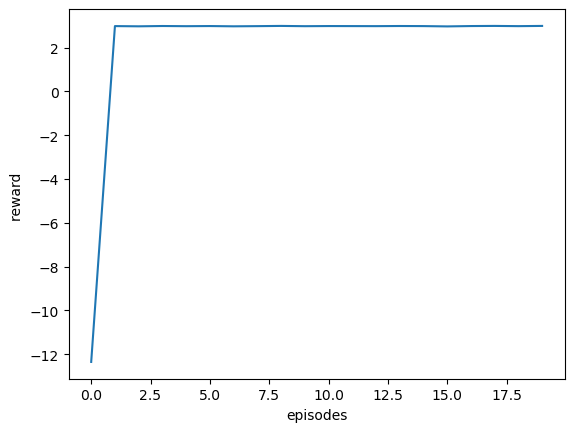

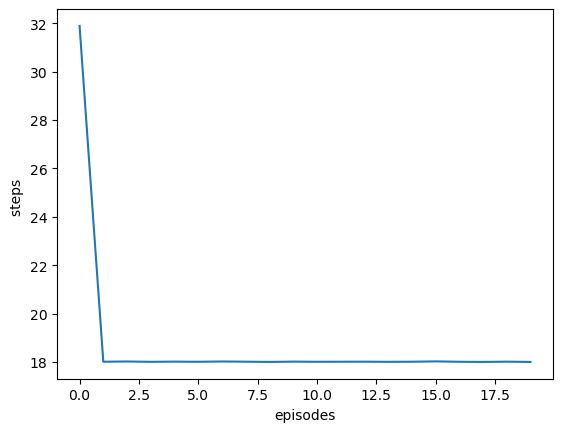

In [8]:
# change agent learning parameters and exploration values
epsilon = {'start': 0.5, 'min': 0.001, 'decay': 0.01} # decrease exploration more quickly
ag = agent(maze.n_states, eps = epsilon, discount = 0.9, learning_rate = 0.2) # adjust discount and learning rate
episodes = 10000
steps = 100
[rewards, steps] = ag.train(maze, episodes, steps)

# display learning
display_learning(rewards, "reward ")
display_learning(steps, "steps ")

# display Q-table
print(ag.Q_table)

# test agent
maze = grid_env(maze_height, maze_width, start, debug = True)
ag.test_agent(maze)


In this cell the learning rate, discount factor, and exploration values were changed by adjusting the learning_rate, discount, and eps dictionary parameters, respectively.

The agent's policy update weights new information versus old information, hence increasing the learning rate increases learning speed. If the learning rate is excessively high, the agent may overreact to noisy or irrelevant information and not converge to an optimal strategy.

Increase the discount factor to help the agent reach the aim. A higher discount factor suggests the agent prioritises future rewards, which may encourage long-term success. However, an extremely high discount factor may cause the agent to ignore immediate gains, making it less likely to live to reap long-term benefits.

The agent will explore randomly if exploration is always maximum. The agent may not recognise appropriate actions for diverse states, which may delay learning and performance.

If exploration reduces rapidly, the agent may quit exploring before finding optimal actions for different situations. The agent may adopt a suboptimal policy and perform poorly.